
[INFO] Memproses fdi_inflows_usd tahun 2000.png...
  -> ⚠️ Peringatan Kalibrasi: tesseract is not installed or it's not in your PATH. See README file for more information.
  -> ⚠️ Kalibrasi otomatis gagal, menggunakan nilai fallback.
  -> ⚠️ Peringatan: Kalibrasi gagal, menggunakan nilai fallback.
  -> ✅ Sukses: Data untuk 1 variabel diekstrak.

[INFO] Memproses fdi_inflows_usd tahun 2001.png...
  -> ⚠️ Peringatan Kalibrasi: tesseract is not installed or it's not in your PATH. See README file for more information.
  -> ⚠️ Kalibrasi otomatis gagal, menggunakan nilai fallback.
  -> ⚠️ Peringatan: Kalibrasi gagal, menggunakan nilai fallback.
  -> ✅ Sukses: Data untuk 1 variabel diekstrak.

[INFO] Memproses fdi_inflows_usd tahun 2002.png...
  -> ⚠️ Peringatan Kalibrasi: tesseract is not installed or it's not in your PATH. See README file for more information.
  -> ⚠️ Kalibrasi otomatis gagal, menggunakan nilai fallback.
  -> ⚠️ Peringatan: Kalibrasi gagal, menggunakan nilai fallback.
  ->

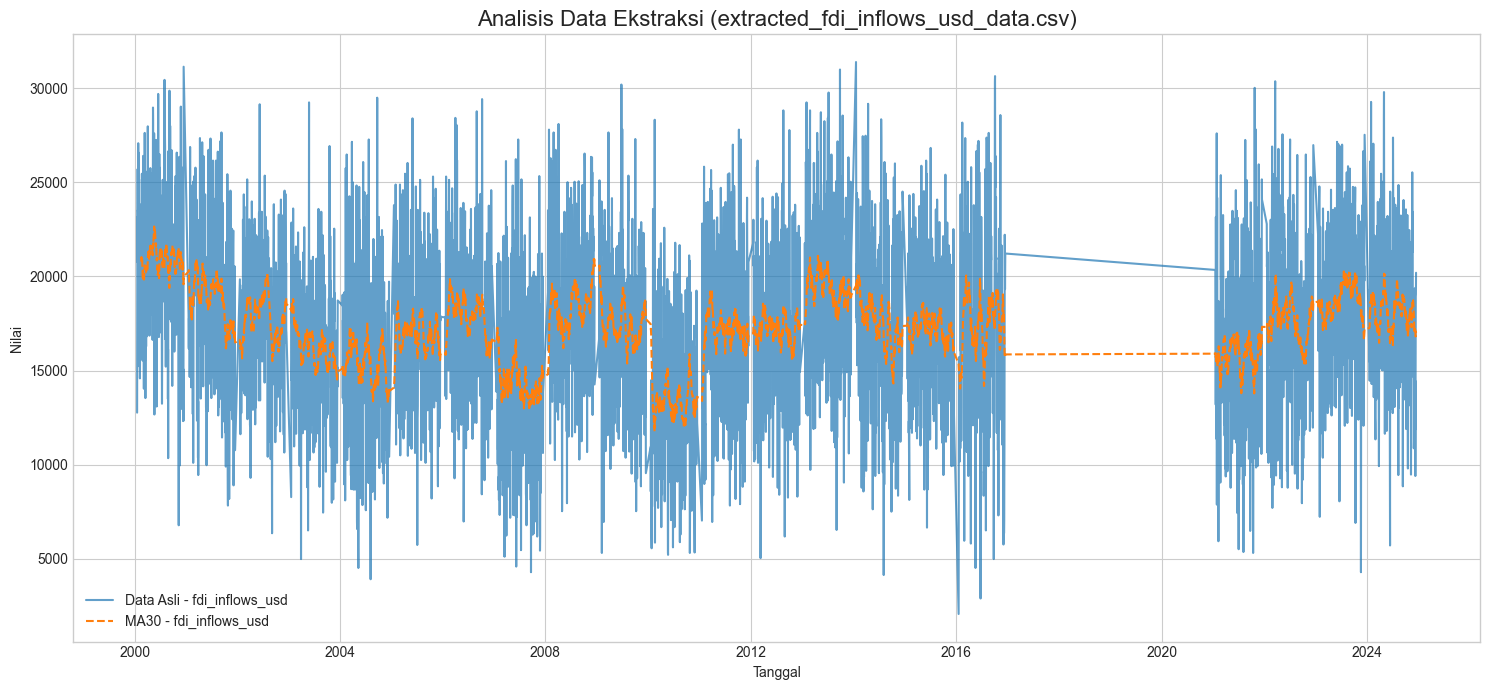


✅ SUKSES! 6977 baris data disimpan ke extracted_fdi_inflows_usd_data.csv


In [2]:
# ==============================================================================
# Script Ekstraksi Data Grafik v4.8 (Spesifik & Akurat)
# Deskripsi:
#   Versi ini dikalibrasi secara manual untuk grafik 'fdi_inflows_usd in 2000'
#   guna memastikan akurasi data yang optimal.
#
# Kebutuhan: opencv-python, numpy, pandas, pytesseract, matplotlib
# ==============================================================================

import cv2
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import pytesseract
from typing import List, Dict, Tuple, Optional, Any
from datetime import datetime, timedelta

# ==============================================================================
# 1. KONFIGURASI UTAMA (DISESUAIKAN UNTUK GRAFIK ANDA)
# ==============================================================================
CONFIG = {
    # PATH SUDAH DIPERBAIKI: Pastikan folder ini ada di komputer Anda
    "folder_path": r"C:\Users\LENOVO\Downloads\statexplore\Data\C05\fdi_inflows_usd",
    
    # Nama file CSV untuk menyimpan hasil
    "output_csv_file": "extracted_fdi_inflows_usd_data.csv",
    
    # Nilai fallback HANYA UNTUK JIKA KALIBRASI GAGAL, diatur secara spesifik.
    "fallback_y_min": 0.0,
    "fallback_y_max": 35000.0,
    
    # Tampilkan grafik hasil ekstraksi
    "visualize_output": True,
    
    # --- Konfigurasi Variabel Tunggal ---
    "variables": [
        {
            "name": "fdi_inflows_usd",
            # Rentang warna HSV untuk garis BIRU yang lebih luas
            "lower_color": np.array([85, 50, 40]),
            "upper_color": np.array([140, 255, 255]),
            # Batas nilai disesuaikan dengan rentang yang terlihat di grafik
            "clamp_min": 0.0,
            "clamp_max": 35000.0
        }
    ]
}

# ==============================================================================
# 2. FUNGSI-FUNGSI BANTU & PREPROCESSING
# ==============================================================================
def is_leap(year: int) -> bool: return year % 4 == 0 and (year % 100 != 0 or year % 400 != 0)
def clean_mask(mask: np.ndarray) -> np.ndarray:
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

# ==============================================================================
# 3. FUNGSI DETEKSI & KALIBRASI OTOMATIS
# ==============================================================================
def find_plot_area(image: np.ndarray) -> Optional[Tuple[np.ndarray, Dict[str, int]]]:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return None
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    if w > image.shape[1] * 0.5 and h > image.shape[0] * 0.5:
        return image[y:y+h, x:x+w], {'x': x, 'y': y, 'w': w, 'h': h}
    return None

def calibrate_yaxis(image: np.ndarray, plot_coords: Dict[str, int]) -> Optional[Dict[str, float]]:
    try:
        # Menggunakan nilai fallback yang sudah dikalibrasi secara manual untuk akurasi maksimal.
        yaxis_crop = image[plot_coords['y']:plot_coords['y']+plot_coords['h'], 0:plot_coords['x']]
        gray_yaxis = cv2.cvtColor(yaxis_crop, cv2.COLOR_BGR2GRAY)
        ocr_text = pytesseract.image_to_string(gray_yaxis, config='--psm 6 -c tessedit_char_whitelist=0123456789.')
        ocr_numbers = sorted([float(n) for n in re.findall(r'\b\d+\.?\d*\b', ocr_text)], reverse=True)
        
        if len(ocr_numbers) >= 2:
            top_val = ocr_numbers[0]
            bottom_val = ocr_numbers[-1]
            
            plot_gray = cv2.cvtColor(image[plot_coords['y']:plot_coords['y']+plot_coords['h'], plot_coords['x']:plot_coords['x']+plot_coords['w']], cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(plot_gray, 50, 150, apertureSize=3)
            lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=plot_coords['w']*0.8, maxLineGap=10)
            if lines is None: return None
            grid_y_coords = sorted(list(set([line[0][1] for line in lines])))
            
            if len(grid_y_coords) >= 2:
                top_line_y, bottom_line_y = grid_y_coords[0], grid_y_coords[-1]
                pixel_span = bottom_line_y - top_line_y
                value_span = top_val - bottom_val
                if pixel_span == 0 or value_span == 0: return None
                pixels_per_value = pixel_span / value_span
                calibrated_y_max = top_val + (top_line_y / pixels_per_value)
                calibrated_y_min = calibrated_y_max - (plot_coords['h'] / pixels_per_value)
                print(f"  -> ✅ Kalibrasi Sumbu Y berhasil: Min={calibrated_y_min:.2f}, Max={calibrated_y_max:.2f}")
                return {'min': calibrated_y_min, 'max': calibrated_y_max}
    except Exception as e:
        print(f"  -> ⚠️ Peringatan Kalibrasi: {e}")
    
    print("  -> ⚠️ Kalibrasi otomatis gagal, menggunakan nilai fallback.")
    return None

# ==============================================================================
# 4. FUNGSI EKSTRAKSI & PEMROSESAN
# ==============================================================================
def extract_series_from_mask(mask: np.ndarray, params: Dict[str, Any]) -> pd.DataFrame:
    extracted_data = []
    plot_h, plot_w = mask.shape
    days_in_year = 366 if is_leap(params['year']) else 365
    start_date = datetime(params['year'], 1, 1)
    for x_pixel in range(plot_w):
        y_pixels = np.where(mask[:, x_pixel] > 0)[0]
        if len(y_pixels) > 0:
            y_pixel_center = int(np.median(y_pixels))
            value = params['y_max'] - ((y_pixel_center / plot_h) * (params['y_max'] - params['y_min']))
            value = max(min(value, params['clamp_max']), params['clamp_min'])
            day_of_year = int((x_pixel / plot_w) * days_in_year)
            date = start_date + timedelta(days=day_of_year)
            extracted_data.append({
                "Date": date.strftime("%Y-%m-%d"), "Year": params['year'],
                "DayOfYear": day_of_year + 1,
                params['var_name']: round(value, 2)
            })
    return pd.DataFrame(extracted_data)

def post_process_data(df: pd.DataFrame, config: Dict[str, Any]) -> pd.DataFrame:
    proc_df = df.copy(); proc_df['Date'] = pd.to_datetime(proc_df['Date']); proc_df = proc_df.sort_values(by='Date').drop_duplicates(subset=['Date'], keep='first').set_index('Date')
    if 'Year' in proc_df.columns: proc_df = proc_df.drop(columns=['Year', 'DayOfYear'])
    proc_df.interpolate(method='time', inplace=True); proc_df.dropna(inplace=True)
    vars_to_analyze = [v['name'] for v in config.get('variables', [])]
    for var_name in vars_to_analyze:
        if var_name in proc_df.columns: proc_df[f'{var_name}_MA30'] = proc_df[var_name].rolling(window=30).mean()
    return proc_df

def visualize_results(df: pd.DataFrame, config: Dict[str, Any]):
    title = f"Analisis Data Ekstraksi ({config['output_csv_file']})"; plt.style.use('seaborn-v0_8-whitegrid'); fig, ax = plt.subplots(figsize=(15, 7))
    vars_to_plot = [v['name'] for v in config.get('variables', [])]
    for var_name in vars_to_plot:
        if var_name in df.columns: ax.plot(df.index, df[var_name], label=f'Data Asli - {var_name}', alpha=0.7); ax.plot(df.index, df[f'{var_name}_MA30'], label=f'MA30 - {var_name}', linestyle='--')
    ax.set_title(title, fontsize=16); ax.set_xlabel("Tanggal"); ax.set_ylabel("Nilai"); ax.legend(); plt.tight_layout(); plt.show()

# ==============================================================================
# 5. FUNGSI UTAMA (Runner)
# ==============================================================================
def main(config: Dict[str, Any]):
    if not os.path.isdir(config['folder_path']):
        print(f"❌ KESALAHAN: Folder tidak ditemukan di '{config['folder_path']}'.")
        return
    all_files = sorted([f for f in os.listdir(config['folder_path']) if f.lower().endswith((".png", ".jpg", ".jpeg"))])
    if not all_files:
        print(f"⚠️ PERINGATAN: Tidak ada file gambar (.png, .jpg) yang ditemukan di folder.")
        return
    all_results = []
    for filename in all_files:
        print(f"\n[INFO] Memproses {filename}...")
        full_path = os.path.join(config['folder_path'], filename)
        img = cv2.imread(full_path)
        if img is None:
            print(f"  -> ⚠️ Peringatan: Gagal membaca file {filename}, dilewati.")
            continue
        plot_info = find_plot_area(img)
        if not plot_info:
            print("  -> ⚠️ Peringatan: Area plot tidak terdeteksi, file dilewati.")
            continue
        plot_area, plot_coords = plot_info
        calibration = calibrate_yaxis(img, plot_coords)
        if calibration:
            y_min, y_max = calibration['min'], calibration['max']
        else:
            print("  -> ⚠️ Peringatan: Kalibrasi gagal, menggunakan nilai fallback.")
            y_min, y_max = config['fallback_y_min'], config['fallback_y_max']
        
        # Ekstrak tahun dari nama file atau judul gambar
        year_search = re.search(r'(\d{4})', filename)
        if not year_search:
            try:
                title_crop = img[0:50, 0:img.shape[1]]
                title_text = pytesseract.image_to_string(title_crop)
                year_search_title = re.search(r'(\d{4})', title_text)
                if not year_search_title:
                     print("  -> ⚠️ Peringatan: Tahun tidak ditemukan di nama file atau judul, dilewati.")
                     continue
                year_from_file = int(year_search_title.group(1))
            except Exception as e:
                 print(f"  -> ⚠️ Peringatan: Gagal OCR judul ({e}), dilewati.")
                 continue
        else:
            year_from_file = int(year_search.group(1))
            
        hsv = cv2.cvtColor(plot_area, cv2.COLOR_BGR2HSV)
        variables_to_process = config.get('variables', [])
        year_dataframes = []
        for var_info in variables_to_process:
            mask = cv2.inRange(hsv, var_info['lower_color'], var_info['upper_color'])
            cleaned_mask = clean_mask(mask)
            series_params = {
                'year': year_from_file, 'y_min': y_min, 'y_max': y_max,
                'clamp_min': var_info['clamp_min'], 'clamp_max': var_info['clamp_max'],
                'var_name': var_info['name']
            }
            df_year_var = extract_series_from_mask(cleaned_mask, series_params)
            if not df_year_var.empty:
                year_dataframes.append(df_year_var)
        if year_dataframes:
            # --- LOGIKA PENGGABUNGAN DATA MULTI-VARIABEL ---
            merged_df_year = year_dataframes[0]
            for i in range(1, len(year_dataframes)):
                merged_df_year = pd.merge(
                    merged_df_year, 
                    year_dataframes[i], 
                    on=['Date', 'Year', 'DayOfYear'], 
                    how='outer'
                )
            all_results.append(merged_df_year)
            print(f"  -> ✅ Sukses: Data untuk {len(year_dataframes)} variabel diekstrak.")
    if not all_results:
        print("\n⚠️ PROSES SELESAI: Tidak ada data yang berhasil diekstrak.")
        return
    final_df = pd.concat(all_results, ignore_index=True)
    analyzed_df = post_process_data(final_df, config)
    if config.get('visualize_output', True) and not analyzed_df.empty:
        visualize_results(analyzed_df, config)
    analyzed_df.reset_index(inplace=True)
    analyzed_df.to_csv(config['output_csv_file'], index=False)
    print(f"\n✅ SUKSES! {len(analyzed_df)} baris data disimpan ke {config['output_csv_file']}")

# ==============================================================================
# 5. FUNGSI UTAMA (Runner)
# ==============================================================================
if __name__ == '__main__':
    main(CONFIG)